In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.pylab import subplots
import matplotlib.mlab as mlab
import matplotlib.patches as patches
from scipy import interpolate 
import seaborn as sns

In [2]:
pl=pd.read_csv('player_attributes.csv')

In [3]:
def add_attributes(pl):
    '''
    pl:DataFrame
    add attributes to pl
    '''
    assert isinstance(pl,pd.DataFrame)
    pl['Attacking']=pl.loc[:,['Crossing','Finishing','Heading Accuracy','Short Passing','Volleys']].mean(1)
    pl['Skill']=pl.loc[:,['Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control']].mean(1)
    pl['Movement']=pl.loc[:,['Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance']].mean(1)
    pl['Power']=pl.loc[:,['Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots']].mean(1)
    pl['Defending']=pl.loc[:,['Marking', 'Standing Tackle', 'Sliding Tackle']].mean(1)
    pl['Goalkeeping']=pl.loc[:,['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']].mean(1)
    pl['Attacking+Skill']=pl.loc[:,['Attacking','Skill']].mean(1)
    pl['Mentality']=pl.loc[:,['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure']].mean(1)
    pl['Midfielding']=pl.loc[:,['Short Passing', 'Dribbling', 'Ball Control', 'Long Passing', 'Crossing']].mean(1)
    ph=pl['Height'].tolist()
    ph=[i.strip('""').split('\'') for i in ph]
    ph=np.array([(int(i[0])*12+int(i[1]))*2.54 for i in ph])
    pl['Hight (cm)']=ph
    pw=pl['Weight'].values*0.4535924
    BMI=pw/ph**2*1e4
    pl['BMI']=BMI
    pv=pl['Value'].tolist()
    pvk=np.array([(i[-1]=='M')*1000+(i[-1]=='K') for i in pv])
    pvn=np.array([float(i[1:].strip('M').strip('K'))for i in pv])
    pl['Value(M)']=pvn*pvk/1000
    plw=pl['Wage'].tolist()
    plwk=[float(i[1:].strip('K')) for i in plw]
    pl['Wage(K)']=plwk
    pl['Overall Skill']=pl['Skill'].values.astype(np.int)
    return pl

In [4]:
pl=add_attributes(pl)

In [5]:
AA=['Attacking']
MA=['Movement']
DA=['Defending']
GKA=['Goalkeeping']
PA=['Power']
MDA=['Midfielding']
AA2=['Crossing','Finishing','Heading Accuracy','Short Passing','Volleys','Attacking']
MA2=['Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',]
DA2=['Marking', 'Standing Tackle', 'Sliding Tackle']
GKA2=['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']
PA2=['Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots']
MDA2=['Short Passing', 'Dribbling', 'Ball Control', 'Long Passing', 'Crossing']

In [6]:
'''
group the players
'''
plp=pl.groupby('Player Category')
sp=plp.get_group('Striker')
gp=plp.get_group('GoalKeeper')
mp=plp.get_group('Midfielder')
dp=plp.get_group('Defender')

In [7]:
'''
adjust the mentality of strikers and defenders
'''
pl.loc[pl.index[pl['Player Category']=='Striker'],'Mentality']=sp.loc[:,['Aggression', 'Positioning', 'Vision', 'Penalties', 'Composure']].mean(1)
pl.loc[pl.index[pl['Player Category']=='Defender'],'Mentality']=dp.loc[:,['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Composure']].mean(1)
op=pd.concat([sp,mp,dp])
sns.set_style("darkgrid")

In [8]:
pvh=pl.sort_values('Overall Rating',ascending=False).head(500)
pvhg=pvh.groupby('Overall Rating').mean()
pvhg['Overall Rating']=pvhg.index


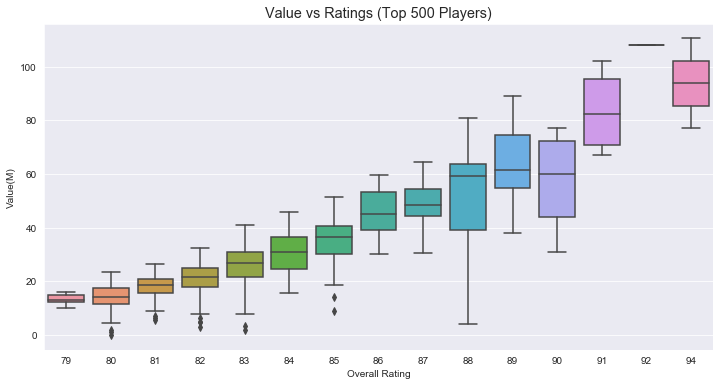

In [9]:
'''
plot box plot of value vs rating
'''
plt.figure(figsize=(12,6))
ax=sns.boxplot(x='Overall Rating',y='Value(M)',data=pvh)
plt.title('Value vs Ratings (Top 500 Players)',fontsize='x-large') 
plt.savefig('./graph/Value vs top 500 Rating.jpg')





C:\Users\z\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x432 with 0 Axes>

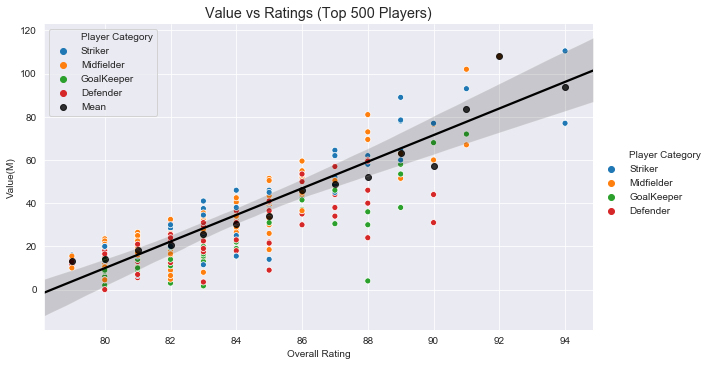

In [10]:
'''
plot scatter plot of value vs rating
'''
plt.figure(figsize=(12,6))
sns.relplot(x='Overall Rating',y='Value(M)',hue='Player Category',aspect=1.7,legend="full",data=pvh,sizes=(20,20))
sns.regplot(x='Overall Rating',y='Value(M)',data=pvhg,color='k',label='Mean')
plt.legend()
plt.title('Value vs Ratings (Top 500 Players)',fontsize='x-large') 
plt.savefig('./graph/Value vs top 500 Rating2.jpg')

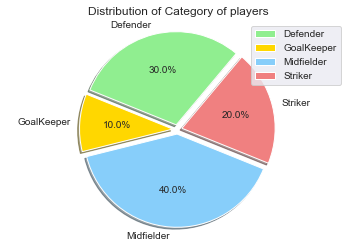

In [11]:
'''
plot pie graph of players' catagrory
'''
sizes=plp.count()['Hight (cm)']
explode=[0.05,0.05,0.05,0.05]
labels=['Defender','GoalKeeper','Midfielder','Striker']
colors=['lightgreen','gold','lightskyblue','lightcoral']
pie=plt.pie(sizes,explode=explode, shadow=True,labels=labels,colors=colors,autopct='%1.1f%%',startangle=50)
plt.axis('equal')
plt.title('Distribution of Category of players')
plt.legend()
plt.savefig("./graph/Distribution of Category of players.jpg")

In [12]:
opH=op.groupby('Hight (cm)').mean()
opW=op.groupby('Weight').mean()
opB=op.groupby('BMI').mean()
gpH=gp.groupby('Hight (cm)').mean()
gpW=gp.groupby('Weight').mean()
gpB=gp.groupby('BMI').mean()

In [13]:
def ddraw(item,unit=''):
    '''
    draw distribution of  single attribute
    item:str
    unit:str
    '''
    assert isinstance(item,str)
    assert isinstance(unit,str)
    x=pl[item]
    bins = np.linspace(x.min(),x.max(),10)
    x1 = np.linspace(x.min(), x.max(), 100)
    normal = norm.pdf(x1, x.mean(), x.std())*x.count()*(bins[1]-bins[0])
    kde = mlab.GaussianKDE(x)
    p1=plt.hist([dp[item],mp[item],sp[item],gp[item]], bins = bins,rwidth=0.8,edgecolor = 'k',stacked= True,label=['Defender','Midfielder','Striker','GoalKeeper'])
    plt.plot(x1,kde(x1)*x.count()*(bins[1]-bins[0]),linewidth = 3,label='Kernel density')
    plt.plot(x1,normal,label='Normal distribution',linewidth = 3)
    plt.grid(True)
    plt.xlabel(item+unit,fontsize='x-large')
    plt.ylabel('Number of players',fontsize='x-large')
    plt.legend(loc= 'best')
    if item== 'Hight (cm)':
        item='Height'
    plt.title('Distribution of '+item,fontsize='x-large')
    plt.savefig('./graph/'+'Distribution of '+item+'.jpg')

In [14]:
def draw_wage(h,m):
    '''
    draw the wage distribution of top players
    h:number of players:int
    m: limit of axis x
    '''
    assert isinstance(h,int)
    assert isinstance(m,int)
    item='Wage(K)'
    dph=dp.head(h)
    sph=sp.head(h)
    mph=mp.head(h)
    gph=gp.head(h)
    dpi=dph[item]
    spi=sph[item]
    mpi=mph[item]
    gpi=gph[item]
    x=pd.concat([dph,sph,mph,gph])[item]
    bins = np.linspace(x.min(),x.max(),10)
    db=bins[1]-bins[0]
    x1 = np.linspace(x.min(), x.max(), 100)
    normals = norm.pdf(x1, spi.mean(), spi.std())*h*db
    normalm = norm.pdf(x1, mpi.mean(), mpi.std())*h*db
    normald = norm.pdf(x1, dpi.mean(), dpi.std())*h*db
    normalg = norm.pdf(x1, gpi.mean(), gpi.std())*h*db
    kde = mlab.GaussianKDE(x)
    p1=plt.hist([sph[item],mph[item],dph[item],mph[item]], bins = bins,rwidth=0.8,\
                edgecolor = 'k',stacked= True,\
                label=['Striker','Midfielder','Defender','GoalKeeper']\
              ,alpha=0.8)
    plt.plot(x1,normals,label='Striker',linewidth = 3,color='b')
    plt.plot(x1,normalm,label='Midfielder',linewidth = 3,color='yellow')
    plt.plot(x1,normald,label='Defender',linewidth = 3,color='lime')
    plt.plot(x1,normalg,label='GoalKeeper',linewidth = 3,color='red')
    plt.grid(True)
    plt.xlabel(item,fontsize='x-large')
    plt.ylabel('Number of players',fontsize='x-large')
    plt.legend(loc= 'best')
    plt.title('Distribution of Wage'+' of top'+str(h)+' players',fontsize='x-large')
    plt.xlim([0,m])
 

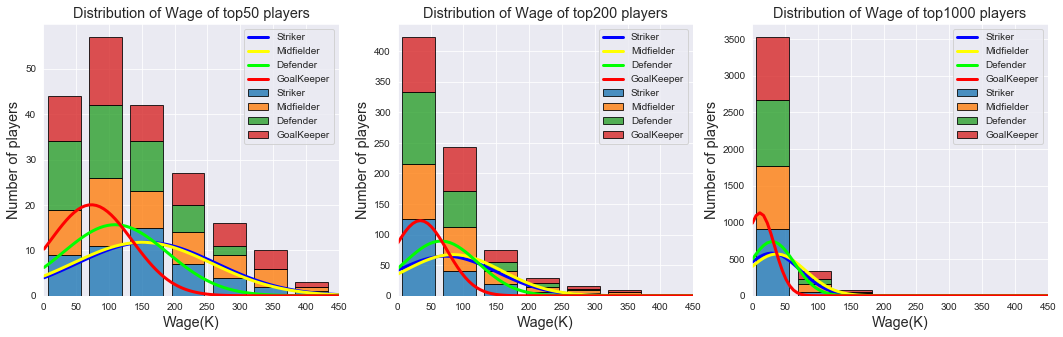

In [15]:
plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
draw_wage(50,450)
plt.subplot(1,3,2)
draw_wage(200,450)
plt.subplot(1,3,3)
draw_wage(1000,450)
plt.savefig('./graph/Wage.jpg')

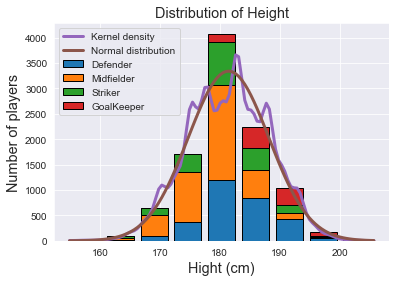

In [16]:
ddraw('Hight (cm)')

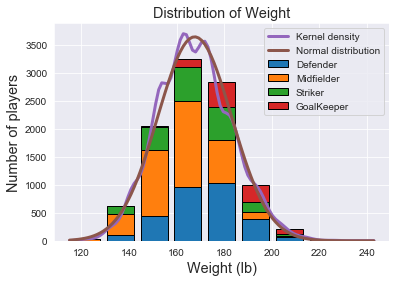

In [17]:
ddraw('Weight',' (lb)')

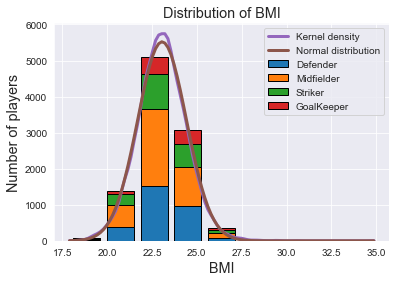

In [18]:
ddraw('BMI')

In [19]:
a='1'
b='a'
isinstance(a+b,str)

True

In [20]:
def ptw(x,item,ply):
    '''
    plot the an attribute vs height, weight and BMI
    ply: specific players:DataFrame
    item:attribute:str
    x: players sorted by height,weight and BMI:list
    '''
    assert isinstance(item,str)
    assert isinstance(x,list)
    assert isinstance(ply,pd.DataFrame)
    fig,axs=subplots(1,3,figsize=(20, 5))
    for i in range(3):
        x1=x[i].index.values
        y1=x[i][item].values
        xv=np.linspace(min(x1),max(x1),100)
        fl=interpolate.interp1d(x1, y1)
        xname=x[i].index.name
        dx=ply[xname]
        #normal = norm.pdf(xv, dx.mean(), dx.std())
        normal=mlab.GaussianKDE(dx)(xv)
        normal=normal+max(normal)/2
        ax=axs[i]
        d=xv[1]-xv[0]    
        for j in range(99):
            ax.add_patch(patches.Rectangle((xv[j],0),d,fl(xv[j]),color='b',linewidth=0,alpha=normal[j]/max(normal)))  
        #ax.plot(x1, y1, '--',linewidth=0)
        ax.set_xlabel(xname+' (lb)'*(xname=='Weight'),fontsize='x-large')    
        ax.set_ylabel(item,fontsize='x-large')
        if xname== 'Hight (cm)':
            xname='Height'
        ax.set_title(item +' vs '+xname,fontsize='x-large')    
        ax.grid(True)
        ax.set_ylim([0,100])
        ax.set_xlim([min(xv),max(xv)])
    fig.savefig('./graph/'+item+'.jpg')

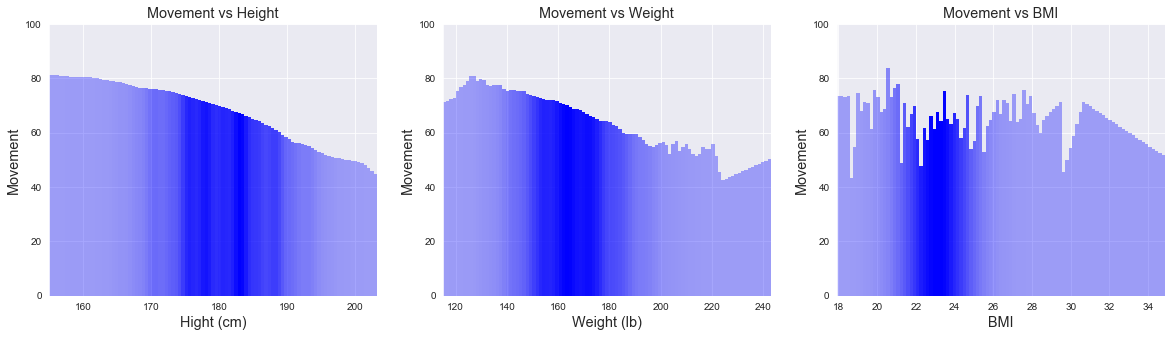

In [21]:
x=[opH,opW,opB]
ply=pd.concat([sp,mp,dp])
ptw(x,'Movement',ply)

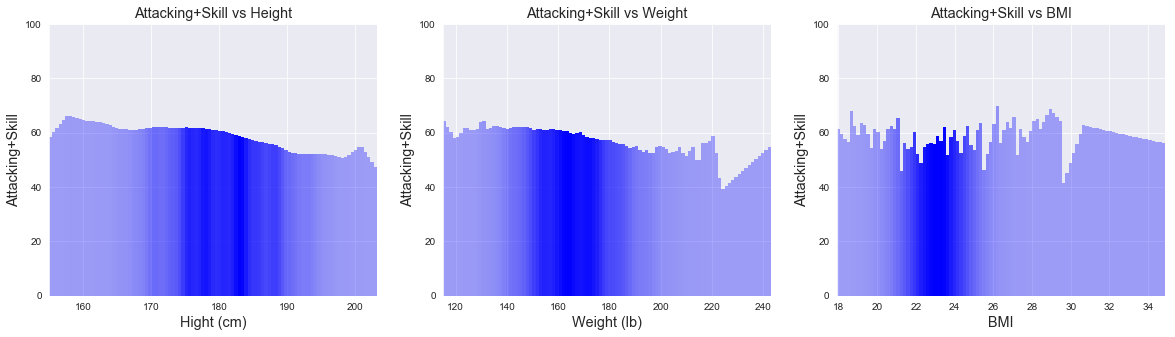

In [22]:
ptw(x,'Attacking+Skill',ply)

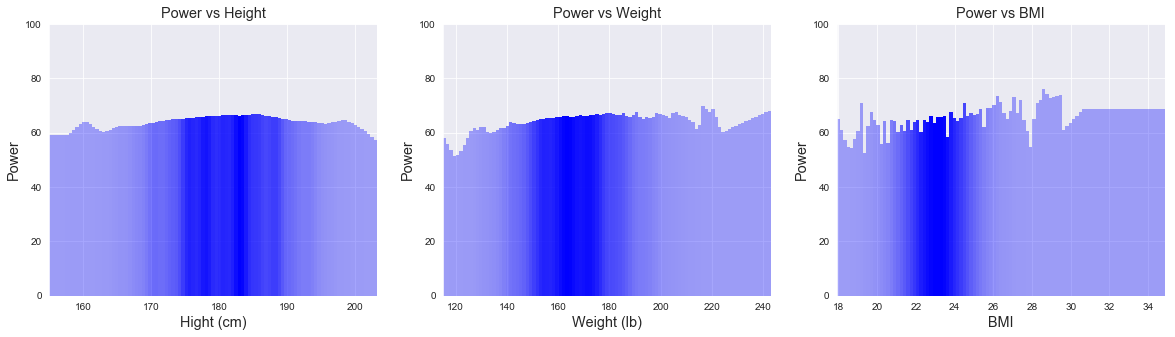

In [23]:
ptw(x,'Power',ply)

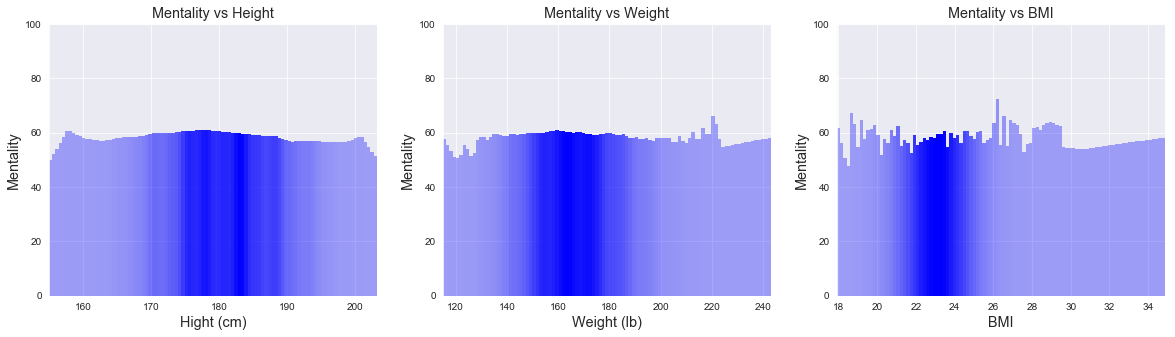

In [24]:
ptw(x,'Mentality',ply)

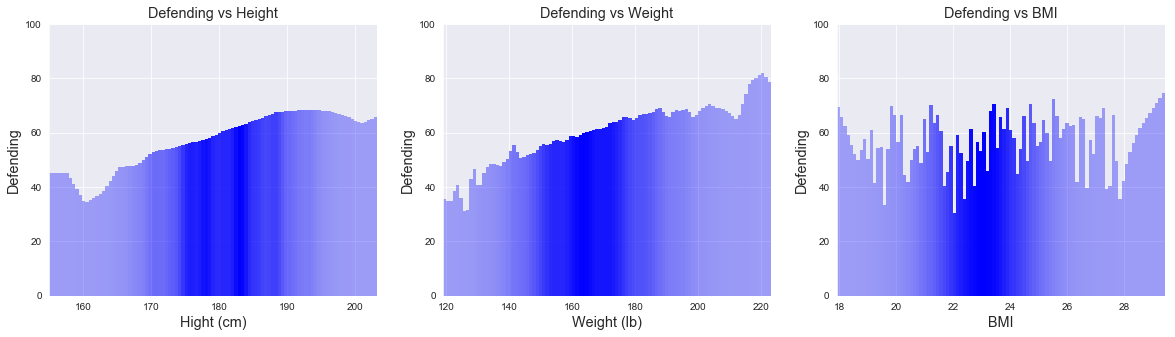

In [25]:
oop=pd.concat([mp,dp])
oopH=oop.groupby('Hight (cm)').mean()
oopW=oop.groupby('Weight').mean()
oopB=oop.groupby('BMI').mean()
x=[oopH,oopW,oopB]
ptw(x,'Defending',oop)

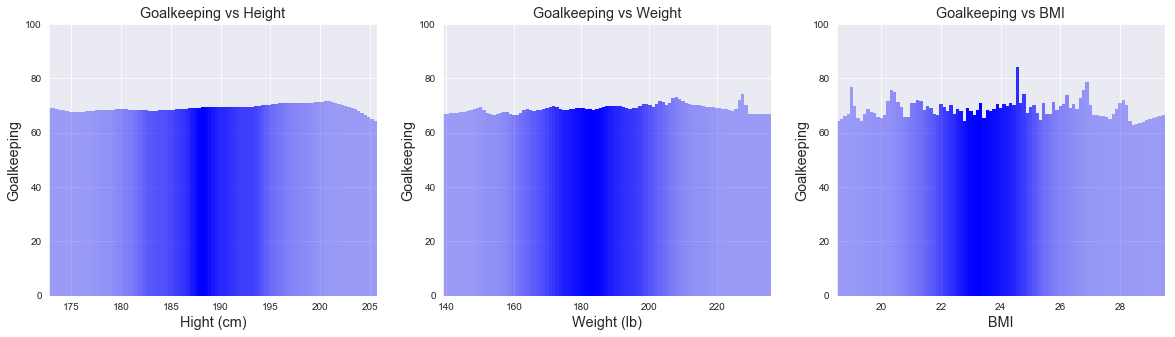

In [26]:
x=[gpH,gpW,gpB]
ptw(x,'Goalkeeping',gp)

In [27]:
def pWH(x,items,ply,pln,itemn):
    '''
    plot the attributes vs height, weight and BMI
    ply: players of specific group:DataFrame
    items:list of attributes:list
    x: players sorted by height,weight
    pln: group name of players:str
    itemn: name of saved graph:str
    '''
    assert isinstance(items,list)
    assert isinstance(x,list)
    assert isinstance(ply,pd.DataFrame)
    assert isinstance(pln,str)
    assert isinstance(itemn,str)
    l=len(items)
    fig,axs=subplots(l,2,figsize=(12, 5*l))
    for j in range(l):
        item=items[j]
        for i in range(2):
            x1=x[i].index.values
            y1=x[i][item].values
            xv=np.linspace(min(x1),max(x1),500)
            fl=interpolate.interp1d(x1, y1)
            xname=x[i].index.name
            dx=ply[xname]
            normal=mlab.GaussianKDE(dx)(xv)
            normal=normal+max(normal)/2
            if l>1:
                ax=axs[j,i]
            else:
                ax=axs[i]
            d=xv[1]-xv[0]    
            for k in range(499):
                ax.add_patch(patches.Rectangle((xv[k],0),d,fl(xv[k]),color='b',linewidth=0,alpha=normal[k]/max(normal)))  
            ax.set_xlabel(xname+' (lb)'*(xname=='Weight'),fontsize='x-large')    
            ax.set_ylabel(item,fontsize='x-large')
            if xname== 'Hight (cm)':
                xname='Height'
            ax.set_title(item +' vs '+xname+' for '+pln,fontsize='x-large')    
            ax.grid(True)
            ax.set_ylim([0,100])
            ax.set_xlim([min(xv),max(xv)])
    fig.savefig('./graph/'+itemn+' of '+pln+'.jpg')

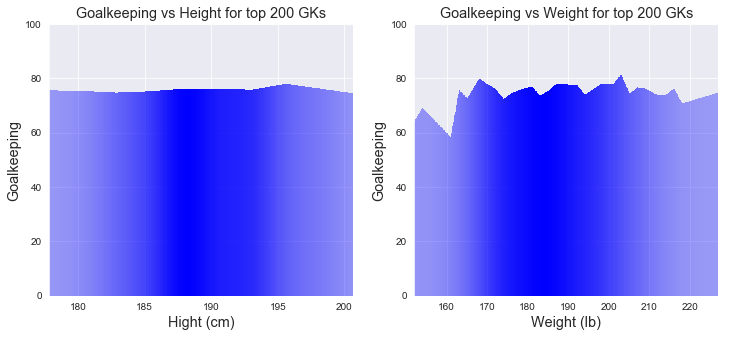

In [28]:
gpt=gp.iloc[:200,:]
gptH=gpt.groupby('Hight (cm)').mean()
gptW=gpt.groupby('Weight').mean()
gptB=gpt.groupby('BMI').mean()
x=[gptH,gptW]
pWH(x,GKA,gpt,'top 200 GKs','Goalkeeping')

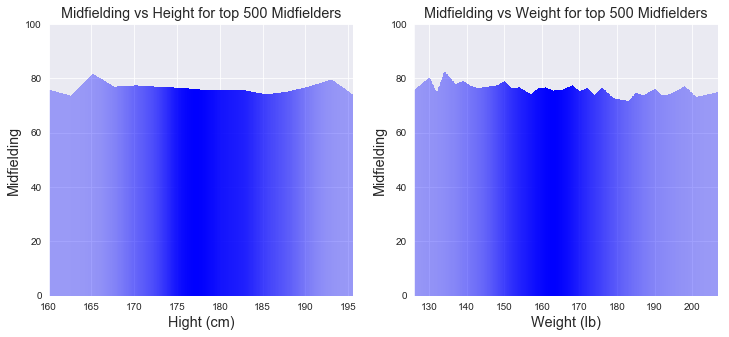

In [29]:
mpt=mp.iloc[:500,:]
mptH=mpt.groupby('Hight (cm)').mean()
mptW=mpt.groupby('Weight').mean()
mptB=mpt.groupby('BMI').mean()
x=[mptH,mptW]
pWH(x,MDA,mpt,'top 500 Midfielders','Midfielding')

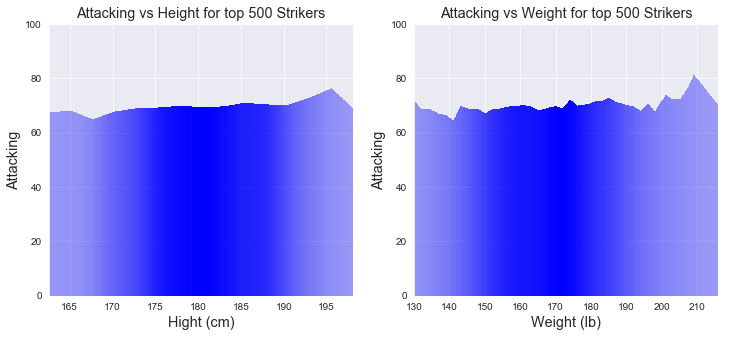

In [30]:
spt=sp.iloc[:500,:]
sptH=spt.groupby('Hight (cm)').mean()
sptW=spt.groupby('Weight').mean()
sptB=spt.groupby('BMI').mean()
x=[sptH,sptW]
pWH(x,AA,spt,'top 500 Strikers','Attacking')

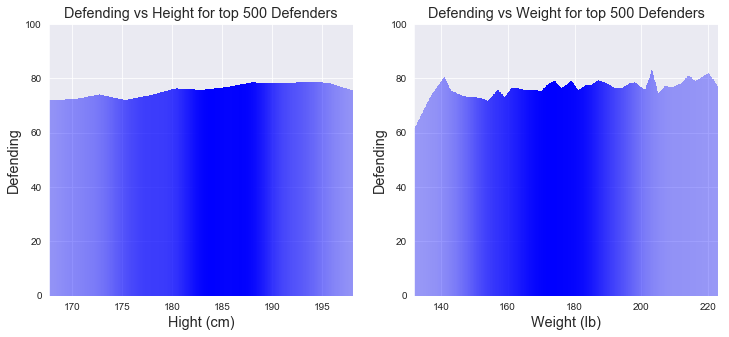

In [31]:
dpt=dp.iloc[:500,:]
dptH=dpt.groupby('Hight (cm)').mean()
dptW=dpt.groupby('Weight').mean()
dptB=dpt.groupby('BMI').mean()
x=[dptH,dptW]
pWH(x,DA,dpt,'top 500 Defenders','Defending')

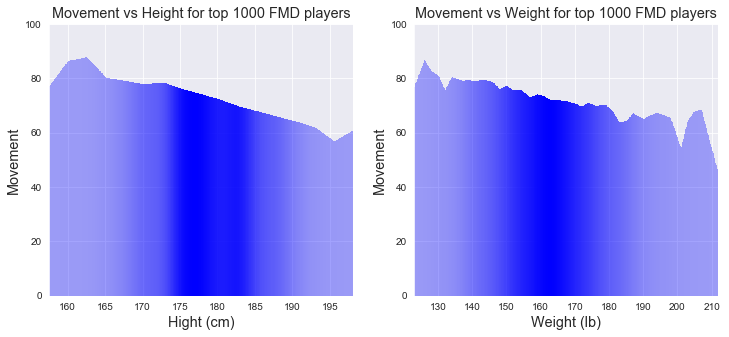

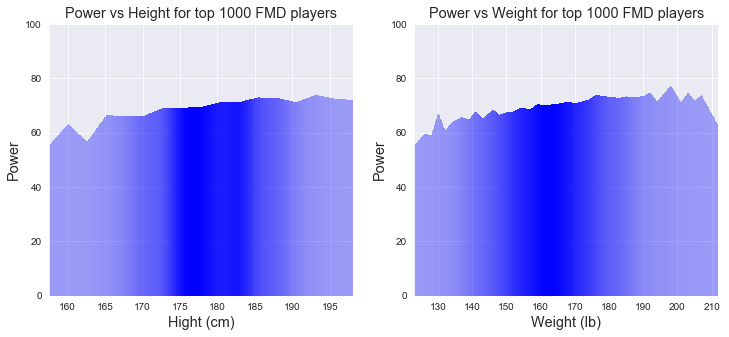

In [32]:
opt=mp.iloc[:1000,:]
optH=opt.groupby('Hight (cm)').mean()
optW=opt.groupby('Weight').mean()
optB=opt.groupby('BMI').mean()
x=[optH,optW]
pWH(x,MA,opt,'top 1000 FMD players','Movement')
pWH(x,PA,opt,'top 1000 FMD players','Power')

In [ ]:
gpt=gp.iloc[:200,:]
gptH=gpt.groupby('Hight (cm)').mean()
gptW=gpt.groupby('Weight').mean()
gptB=gpt.groupby('BMI').mean()
x=[gptH,gptW]
pWH(x,GKA2,gpt,'top 200 GKs','GK attributes')

In [ ]:
mpt=mp.iloc[:500,:]
mptH=mpt.groupby('Hight (cm)').mean()
mptW=mpt.groupby('Weight').mean()
mptB=mpt.groupby('BMI').mean()
x=[mptH,mptW]
pWH(x,MDA2,mpt,'top 500 Midfielders','Midfielding attributes')

In [ ]:
spt=sp.iloc[:500,:]
sptH=spt.groupby('Hight (cm)').mean()
sptW=spt.groupby('Weight').mean()
sptB=spt.groupby('BMI').mean()
x=[sptH,sptW]
pWH(x,AA2,spt,'top 500 Strikers','Attacking attributes')

In [ ]:
dpt=dp.iloc[:500,:]
dptH=dpt.groupby('Hight (cm)').mean()
dptW=dpt.groupby('Weight').mean()
dptB=dpt.groupby('BMI').mean()
x=[dptH,dptW]
pWH(x,DA2,dpt,'top 500 Defenders','Defending attributes')

In [ ]:
opt=mp.iloc[:1000,:]
optH=opt.groupby('Hight (cm)').mean()
optW=opt.groupby('Weight').mean()
optB=opt.groupby('BMI').mean()
x=[optH,optW]
pWH(x,MA2,opt,'top 1000 FMD players','Movement attributes')
pWH(x,PA2,opt,'top 1000 FMD players','Power attributes')